In [2]:
!pip install ortools
!pip install pulp
!pip install mip
!pip install deap

     |████████████████████████████████| 13.7MB 327kB/s 
     |████████████████████████████████| 1.0MB 45.9MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 40.6MB 82kB/s 
     |████████████████████████████████| 48.0MB 81kB/s 
     |████████████████████████████████| 163kB 5.1MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from pulp import *
from mip import Model, xsum, maximize, BINARY
from scipy.optimize import linear_sum_assignment
from scipy.stats import lognorm
import itertools
import random
from deap import creator, base, tools, algorithms
import operator
import matplotlib.pyplot as plt

In [2]:
start_date = '2020-01-20 08:30:00'
end_date = '2020-01-20 08:35:00'

df = pd.read_csv('/content/drive/MyDrive/ECE1724/yellow_tripdata_2020-01.csv')
df = df.drop(['VendorID', \
              'passenger_count', \
              'RatecodeID', \
              'store_and_fwd_flag', \
              'payment_type', \
              'fare_amount', \
              'extra', \
              'mta_tax', \
              'tip_amount', \
              'tolls_amount', \
              'improvement_surcharge',\
              'total_amount',\
              'congestion_surcharge',\
              'PULocationID',\
              'DOLocationID'] , axis=1)

df['tpep_pickup_datetime'] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)
df = df.sort_values(by=['tpep_pickup_datetime'])
mask = (df['tpep_pickup_datetime'] > start_date) & (df['tpep_pickup_datetime'] <= end_date)
dfs = df.loc[mask]
dfs['trip_duration'] = dfs.tpep_dropoff_datetime - dfs.tpep_pickup_datetime
dfs['trip_duration_second'] = dfs.apply(lambda row : row['trip_duration'].total_seconds(), axis = 1)

dfs.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


(450, 5)

In [3]:
dfs.shape

(450, 5)

In [4]:
df_instance = dfs.drop(["trip_duration", "tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1).reset_index(drop=True)

In [5]:
deficit = 1
estimated_sigma, loc, scale = lognorm.fit(df_instance['trip_distance'])
estimated_mu = np.log(scale)
l,w = df_instance.shape
drivers = []
n_cars = df_instance.shape[0] - deficit
for i in range(0, n_cars):
    column_name = 'car_' + str(i)
    drivers.append(column_name)
    dis_to_pickup = np.random.lognormal(estimated_mu, estimated_sigma, l)
    df_instance[column_name] = dis_to_pickup

In [6]:
df_instance.head()

,trip_distance,trip_duration_second,car_0,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8,car_9,car_10,car_11,car_12,car_13,car_14,car_15,car_16,car_17,car_18,car_19,car_20,car_21,car_22,car_23,car_24,car_25,car_26,car_27,car_28,car_29,car_30,car_31,car_32,car_33,car_34,car_35,car_36,car_37,...,car_409,car_410,car_411,car_412,car_413,car_414,car_415,car_416,car_417,car_418,car_419,car_420,car_421,car_422,car_423,car_424,car_425,car_426,car_427,car_428,car_429,car_430,car_431,car_432,car_433,car_434,car_435,car_436,car_437,car_438,car_439,car_440,car_441,car_442,car_443,car_444,car_445,car_446,car_447,car_448
0,0.50,140.0,2.191124,0.454267,3.723165,3.198770,0.613219,6.000103,0.339381,0.524159,2.561860,3.823229,14.001291,4.699861,0.791257,9.281331,1.954888,2.072010,2.012471,3.950734,14.799311,2.019077,23.624203,6.263887,0.615437,3.685204,3.173144,8.526887,0.394110,7.019403,1.533273,2.131579,5.402925,0.162473,3.557478,1.672267,2.004878,1.464931,0.216503,4.522551,...,1.670497,2.937863,0.446674,14.631861,4.660224,2.552283,0.751913,0.594106,1.131293,4.078792,0.490433,1.716996,0.286019,6.772043,1.636929,9.385192,0.996766,1.003651,1.588648,0.167171,0.876564,3.629284,2.013951,2.339748,1.870586,1.320810,0.329891,21.161330,2.608033,0.774327,1.571109,0.977438,5.669471,1.114201,1.994844,1.222217,3.636557,1.550478,1.499525,1.512970
1,2.58,85115.0,3.443316,1.763681,1.271060,0.496121,0.405458,3.487617,0.251389,1.328632,0.993733,1.028184,0.940252,1.610184,0.734799,2.043006,1.775003,2.791002,0.708970,1.688308,2.223794,3.218561,0.416047,12.459230,0.553016,0.977668,1.385122,1.424764,1.395926,0.590286,0.799392,1.007337,0.757668,4.377703,5.026127,1.913228,0.583244,3.005659,7.668823,0.792597,...,24.471587,0.314015,6.531406,12.208242,1.673449,1.101061,2.128730,2.266664,5.037375,6.384902,1.188550,2.877600,1.292685,1.303804,3.526347,0.690936,7.522264,1.327279,3.885993,5.442130,0.605729,6.988497,0.885352,0.822004,2.468370,1.296195,5.151782,0.845296,2.319551,4.067841,0.570950,13.734011,1.216438,0.450406,2.042174,1.735659,0.603141,0.596143,1.836098,4.605320
2,1.41,460.0,0.367841,1.518238,1.997032,0.645898,1.414041,2.171923,2.874430,12.175528,3.205976,1.348221,0.442204,1.621216,3.550310,1.183641,1.235738,5.745206,1.129017,8.748639,0.888803,1.583052,1.479978,3.823700,3.520944,1.517984,0.378743,0.575684,16.738030,2.850079,0.765469,2.116515,2.139532,7.623206,1.746501,0.793501,1.326835,1.439068,4.029585,1.834081,...,0.335201,0.615110,2.647464,1.900844,1.496766,6.025936,0.199020,2.842507,8.259035,1.052507,1.806420,0.815579,1.308383,0.385679,3.934902,3.373694,0.284651,0.375364,1.707267,2.365317,1.580905,1.067574,1.251988,0.925252,12.871932,3.047085,1.623351,1.662155,1.291183,3.177538,1.919625,0.754725,2.582285,1.872793,1.006986,1.527634,3.339655,0.399786,1.912964,1.685963
3,2.84,684.0,0.171503,0.852192,1.491383,2.438706,0.114350,1.638533,1.786603,3.900764,2.794733,4.333521,4.075632,5.675153,1.253076,0.546857,1.919293,1.123633,1.526790,3.312771,0.510095,13.523437,0.415058,0.779566,7.076745,2.302032,0.753638,0.521706,2.239619,0.292863,1.561108,7.855252,2.939401,2.723385,6.532782,3.452851,7.151295,3.860528,1.924884,0.647801,...,1.646033,3.369818,7.594454,1.648540,0.886734,0.185597,0.860146,1.134203,3.315698,1.483013,2.730970,3.674987,0.808867,0.967842,3.433203,1.169697,3.666342,6.501814,3.725865,1.905894,0.530090,0.942818,1.845645,0.514335,4.140949,7.300954,1.349472,0.949637,1.323225,9.284993,0.527555,1.250007,1.444760,4.432225,11.237104,3.304260,0.375055,1.151626,1.248121,0.588464
4,2.50,427.0,0.723678,20.648890,3.641983,2.418519,14.833531,0.603193,1.232148,2.206998,1.839083,7.859698,2.253773,7.304135,1.226671,1.630468,2.045414,1.744956,0.443677,9.089687,27.302232,1.823600,0.473136,2.015125,3.630021,0.877040,0.425497,6.769754,0.957477,3.375546,3.907213,0.988329,3.187226,1.306472,0.911622,15.348176,1.510361,0.271137,1.045472,1.975331,...,0.729164,1.810977,4.362461,0.448123,5.163733,0.478600,3.450032,7.430606,1.321501,2.644226,3.139921,0.761280,12.911373,2.942678,3.

In [7]:
sam = ['trip_distance', 'trip_duration_second', 'car_0', 'car_1', 'car_2', 'car_3', 'car_4', 'car_5', 'car_6', 'car_7', 'car_8']#, 'car_9', 'car_10', 'car_11' ]
drivers = ['car_0', 'car_1', 'car_2', 'car_3', 'car_4', 'car_5', 'car_6', 'car_7', 'car_8']#, 'car_9', 'car_10', 'car_11']

In [8]:
df_instance = df_instance[sam]

In [9]:
df_instance = df_instance.head(10)

In [10]:
drivers

['car_0',
 'car_1',
 'car_2',
 'car_3',
 'car_4',
 'car_5',
 'car_6',
 'car_7',
 'car_8']

In [11]:
df_instance.head(15)

,trip_distance,trip_duration_second,car_0,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8
0,0.50,140.0,2.191124,0.454267,3.723165,3.198770,0.613219,6.000103,0.339381,0.524159,2.561860
1,2.58,85115.0,3.443316,1.763681,1.271060,0.496121,0.405458,3.487617,0.251389,1.328632,0.993733
2,1.41,460.0,0.367841,1.518238,1.997032,0.645898,1.414041,2.171923,2.874430,12.175528,3.205976
3,2.84,684.0,0.171503,0.852192,1.491383,2.438706,0.114350,1.638533,1.786603,3.900764,2.794733
4,2.50,427.0,0.723678,20.648890,3.641983,2.418519,14.833531,0.603193,1.232148,2.206998,1.839083
5,0.53,153.0,9.482835,5.175637,6.326061,0.729634,0.480171,6.049143,0.332104,4.731935,3.135406
6,1.06,348.0,10.572629,2.747436,0.760446,4.767224,0.991744,1.579659,0.906870,1.935985,4.271546
7,0.81,332.0,25.776287,1.688781,1.186581,4.999774,2.596023,2.709601,0.394189,1.226427,0.328162
8,6.27,572.0,0.799162,1.630443,1.801011,1.780999,3.455231,0.709126,0.262241,0.089702,8.724218
9,17.38,2150.0,0.853653,1.667708,2.202339,0.656368,1.714763,6.623759,3.502303,1.083034,8.114894


In [12]:
df_instance['price'] = 0.0
def price(trip):
  price = (0.3 * trip["trip_distance"] + 0.25 * (trip["trip_duration_second"]/60)) + 5
  return price

df_instance['price'] = df_instance.apply(lambda row: price(row), axis=1 )

In [13]:
df_instance.head()

,trip_distance,trip_duration_second,car_0,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8,price
0,0.50,140.0,2.191124,0.454267,3.723165,3.198770,0.613219,6.000103,0.339381,0.524159,2.561860,5.733333
1,2.58,85115.0,3.443316,1.763681,1.271060,0.496121,0.405458,3.487617,0.251389,1.328632,0.993733,360.419833
2,1.41,460.0,0.367841,1.518238,1.997032,0.645898,1.414041,2.171923,2.874430,12.175528,3.205976,7.339667
3,2.84,684.0,0.171503,0.852192,1.491383,2.438706,0.114350,1.638533,1.786603,3.900764,2.794733,8.702000
4,2.50,427.0,0.723678,20.648890,3.641983,2.418519,14.833531,0.603193,1.232148,2.206998,1.839083,7.529167


In [14]:
def cost(trip, driver):
  trip_cost = (trip["trip_distance"] + trip[driver])*0.1
  revenue = trip["price"] - trip_cost 
  return revenue

In [15]:
for driver in drivers:
  df_instance[driver] = df_instance.apply(lambda row: cost(row, driver), axis=1 )

df_instance.drop(["price", "trip_distance", "trip_duration_second"], axis=1, inplace=True)
df_instance.reset_index(inplace=True, drop=True)

In [16]:
df_instance.head()

,car_0,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8
0,5.464221,5.637907,5.311017,5.363456,5.622011,5.083323,5.649395,5.630917,5.427147
1,359.817502,359.985465,360.034727,360.112221,360.121288,359.813072,360.136694,360.028970,360.062460
2,7.161883,7.046843,6.998963,7.134077,7.057263,6.981474,6.911224,5.981114,6.878069
3,8.400850,8.332781,8.268862,8.174129,8.406565,8.254147,8.239340,8.027924,8.138527
4,7.206799,5.214278,6.914968,7.037315,5.795814,7.218847,7.155952,7.058467,7.095258


In [17]:
df_instance.shape # (trips, cars)

(10, 9)

In [18]:
revenues = df_instance.values
num_of_trips = df_instance.shape[0]
num_of_cars = df_instance.shape[1]
diff = num_of_trips - num_of_cars

In [19]:
num_of_cars

9

In [20]:
num_of_trips

10

In [166]:
def mutate(losers):
  mutants = []
  for loser in losers:
    a = np.array(loser)+1
    mutant = tools.mutShuffleIndexes(a, 0.9)[0]
    m = mutant - 1
    mutants.append(tuple(m))
  return mutants


def crossover(parents):
  childern = [] 
  for i in range(int(len(parents)/2)):
    parent_1 = parents[i]
    parent_2 = parents[len(parents) - 1 - i]
    a = np.array(parent_1)+1
    b = np.array(parent_2)+1
    child1, child2 = tools.cxPartialyMatched(a, b)
    c1 = child1 - 1
    c2 = child2 - 1
    childern.append(tuple(c1))
    childern.append(tuple(c2))
  return childern


def decode(soln):
  d = np.array(soln)
  for i, val in np.ndenumerate(d):
    if val < 0:
      d[i] = 0
    else:
      d[i] = 2**val

  assig = (((d[:,None] & (1 << np.arange(num_of_cars)))) > 0).astype(int)

  return d, assig


def calc_total_rev(soln):
  d = np.array(soln)
  for i, val in np.ndenumerate(d):
    if val < 0:
      d[i] = 0
    else:
      d[i] = 2**val

  assig = (((d[:,None] & (1 << np.arange(num_of_cars)))) > 0).astype(int)
  out = revenues*assig
  total_revenue  = sum(sum(out))
  return total_revenue


def evaluate_best(population):
  scores = {}
  max_score = -100
  for soln in population:
    score = calc_total_rev(soln)
    scores[str(soln)]= score
    if score > max_score:
      key_max_1 = soln
      max_score = score
  key_max = max(scores.items(), key=operator.itemgetter(1))[0]
  return key_max, scores[key_max], key_max_1, scores


def select_parents(population, num_contestants):
  parents=[]
  losers=[]
  for i in range(int(len(population)/2)):
    total_revenue_1 = calc_total_rev(population[i])
    total_revenue_2 = calc_total_rev(population[len(population) - 1 - i])
    if total_revenue_1 > total_revenue_2:
      winner = i 
      parents.append(population[winner])
      loser = len(population) -1  - i
      losers.append(population[loser])
    else:
      winner = len(population) -1  - i 
      parents.append(population[winner])
      loser = i
      losers.append(population[loser])

  return parents, losers


In [74]:
l2 = [i for i in range(num_of_cars)]
for i in range(diff):
  l2.append(-1)
lis2 = np.array(sorted(l2))#+1
permutations = list(itertools.permutations(lis2))

In [75]:
len(permutations)

3628800

In [117]:
%%time
sco = []
max_reven = -100
for soln in permutations:
  rev = calc_total_rev(soln)
  if rev > max_reven:
    max_reven = rev
    optimum_soln = soln

  sco.append(rev)

print(max(sco))

427.65742818831126
CPU times: user 2min 10s, sys: 378 ms, total: 2min 10s
Wall time: 2min 10s


In [118]:
optimum_soln

(1, 6, 0, 4, 5, -1, 2, 8, 7, 3)

In [119]:
calc_total_rev(optimum_soln)

427.65742818831126

In [143]:
num_contestants = 2
population_size = 32
num_iter = 50

In [144]:
initial_population = []
visited_solutions = []
for i in range(population_size):
  indx = random.randrange(len(permutations))
  initial_population.append(permutations[indx])
  visited_solutions.append(indx)

In [145]:
#visited_solutions

In [146]:
len(initial_population)

32

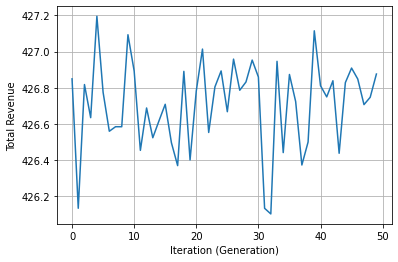

CPU times: user 309 ms, sys: 1 ms, total: 310 ms
Wall time: 311 ms


In [167]:
%%time
population = initial_population
y = []
x = []
for itr in range(num_iter):
  x.append(itr)
  parents, losers = select_parents(population, num_contestants)
  childern = crossover(parents)
  mutants = mutate(losers)
  new_population =  childern + mutants
  population = new_population
  a, b, c, scores = evaluate_best(population)
  y.append(b)
  #print("best_soln: ", a, "revenue: ", b)
  #print("#############################################")

plt.plot(x, y)
plt.xlabel("Iteration (Generation)")
plt.ylabel("Total Revenue")
plt.grid()
plt.show()

In [168]:
a

'(-1, 8, 1, 4, 2, 6, 5, 7, 3, 0)'

In [170]:
scores[a]

426.87605222992636

In [171]:
d, assig = decode(c)
cars = list(df_instance.columns)
trips = list(df_instance.index)

In [172]:
pd.DataFrame(assig, index=trips, columns=cars)

,car_0,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0
8,0,0,0,1,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0


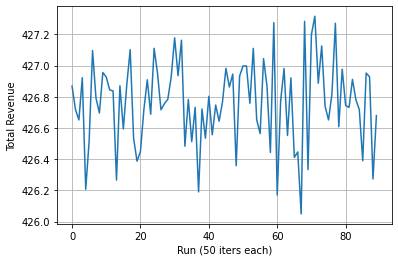

CPU times: user 8.02 s, sys: 7.86 ms, total: 8.02 s
Wall time: 8.03 s


In [173]:
%%time
runs = []
bests = []
for run in range(90):
  runs.append(run)
  initial_population = []
  visited_solutions = []
  for i in range(population_size):
    indx = random.randrange(len(permutations))
    initial_population.append(permutations[indx])
    visited_solutions.append(indx)


  population = initial_population
  for itr in range(num_iter):
  
    parents, losers = select_parents(population, num_contestants)
    childern = crossover(parents)
    mutants = mutate(losers)
    new_population =  childern + mutants
    population = new_population

  a, b, c, scores = evaluate_best(population)
  mm = calc_total_rev(c)
  bests.append(mm)

plt.plot(runs, bests)
plt.xlabel("Run (50 iters each)")
plt.ylabel("Total Revenue")
plt.grid()
plt.show()

In [163]:
import statistics
statistics.mean(bests)

426.6160493973451

In [165]:
statistics.stdev(bests)

0.3943852072640365